## Predicting Satellite Congestion Risk: Traditional Machine Learning Approach

In this we explore how to predict the congestion risk of satellites using machine learning. As the space industry rapidly grows, satellite congestion becomes an increasingly important problem, so being able to predict the risk of any current or future satellites is very useful. We'll use a dataset containing various satellite parameters to build a model that can classify satellites into different congestion risk categories, Low, Medium and High.


### 1. Setting Up Our Environment and Loading Data

Before we start, we need to import the necessary libraries. We'll be using `pandas` for data manipulation, `matplotlib` and `seaborn` for visualizations, and `sklearn` (Scikit-learn) for machine learning tasks.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import class_weight
import tensorflow as tf

Next, we'll load our dataset. The data comes from a Kaggle dataset containing an orbital catalog of satellites. We'll load it into a `pandas DataFrame`, which is a data structure that's very common and useful for data analysis in Python.

Then I display the first few rows using (`df.head()`) to get a look at the data and use `df.info()` to see a summary of the columns, their data types, and whether they contain any missing values. This is useful to understand the types of data we're working with, and which are descriptive catergorical columns, and which contain data to train on.

In [ ]:
# https://www.kaggle.com/datasets/karnikakapoor/satellite-orbital-catalog

In [ ]:
# download kaggle dataset from google drive, and import as a pandas dataframe
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1i4FdBT71ale29-1ido9Q0HNeNzOZ6lFN')

# display some info about the dataframe
display(df.head())
df.info()

,norad_id,name,object_type,satellite_constellation,altitude_km,altitude_category,orbital_band,congestion_risk,inclination,eccentricity,launch_year_estimate,days_in_orbit_estimate,orbit_lifetime_category,mean_motion,epoch,data_source,snapshot_date,country,last_seen
0,900,CALSPHERE 1,PAYLOAD,Other,976.868247,Low LEO,LEO-Polar,LOW,90.2215,0.002710,2023,0,<1yr,13.763481,2025-12-03 11:44:40.165728,celestrak,2025-12-03,US,2025-12-03
1,902,CALSPHERE 2,PAYLOAD,Other,1061.675587,Mid LEO,LEO-Polar,LOW,90.2363,0.002044,2023,0,<1yr,13.528815,2025-12-03 06:12:53.330976,celestrak,2025-12-03,US,2025-12-03
2,1361,LCS 1,PAYLOAD,Other,2787.874819,High LEO,MEO,LOW,32.1427,0.001343,2023,0,<1yr,9.893094,2025-12-03 11:26:30.164064,celestrak,2025-12-03,US,2025-12-03
3,1512,TEMPSAT 1,PAYLOAD,Other,1133.286101,Mid LEO,LEO-Polar,HIGH,89.9888,0.007142,2023,0,<1yr,13.335811,2025-12-03 09:48:38.369088,celestrak,2025-12-03,US,2025-12-03
4,1520,CALSPHERE 4A,PAYLOAD,Other,1123.330697,Mid LEO,LEO-Polar,HIGH,89.9092,0.006823,2023,0,<1yr,13.362367,2025-12-03 09:46:39.199296,celestrak,2025-12-03,US,2025-12-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13610 entries, 0 to 13609
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   norad_id                 13610 non-null  int64  
 1   name                     13610 non-null  object 
 2   object_type              13610 non-null  object 
 3   satellite_constellation  13610 non-null  object 
 4   altitude_km              13610 non-null  float64
 5   altitude_category        13610 non-null  object 
 6   orbital_band             13610 non-null  object 
 7   congestion_risk          13610 non-null  object 
 8   inclination              13610 non-null  float64
 9   eccentricity             13610 non-null  float64
 10  launch_year_estimate     13610 non-null  int64  
 11  days_in_orbit_estimate   13610 non-null  int64  
 12  orbit_lifetime_category  13610 non-null  object 
 13  mean_motion              13610 non-null  float64
 14  epoch                 

### 2. Data Preprocessing: Getting Our Data Ready for the Model

Machine learning models often require data in a specific format. Our goal is to predict `'congestion_risk'`, so this will be our target variable Y, what we're trying to predict, and all other relevant columns will be our features X, the information we use to make the prediction.

In this step I:

*   **Separate Features and Target**: We'll create `x` for features and `y` for the target variable.
*   **Exclude Irrelevant Columns**: Some columns, like `norad_id` or `name`, are descriptive but don't help the model predict congestion risk. We'll remove these.
*   **Handle Categorical Data**: Many of our columns (like `'object_type'`, `'country'`) are categorical, meaning they represent categories rather than numerical values. Machine learning models require numbers instead of words, so we'll convert these using `OrdinalEncoder`. This replaces these words with numbers, for example the congestion risk is changed from "high" "medium" and "low" to "0" "1" "2".
*   **Split Data for Training and Testing**: It's important to keep a set of data the algorithm hasn't seen before to test the accuracy of the model, or we  an potentially run into overfitting, where the model predicts exactly that dataset, but it doesn't work for any other. So, we split our dataset into `x_train`, `y_train` for training the model and `x_test`, `y_test` for testing its performance. We also use `random_state=42` to ensure our split is reproducible every time.


In [ ]:
# separate features (x) and target (y)
x = df.drop('congestion_risk', axis=1)
y = df['congestion_risk']

# exclude descriptive columns not used for training data
exclude_columns = ['norad_id', 'name', 'epoch', 'data_source', 'snapshot_date', 'last_seen']
categorical_cols = ['object_type', 'satellite_constellation', 'altitude_category', 'orbital_band', 'orbit_lifetime_category', 'country']

# drop excluded columns
x_processed = x.drop(columns=exclude_columns, errors='ignore')

# use ordinal encoding to change categorical data to numerical for training
encoder = OrdinalEncoder()
x_processed[categorical_cols] = encoder.fit_transform(x_processed[categorical_cols])

# split data into training and testing sets with the processed data
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=42)

### 3. Training Our Prediction Model: The Random Forest Classifier

Now that our data is prepared and in the format the it expects, we can train a machine learning model. For this task we're using a `RandomForestClassifier` model. This is a powerful and versatile model that works by building many decision trees and combining their predictions.

*   **`n_estimators=100`**: This means the model will build 100 decision trees.
*   **`random_state=42`**: Again, this ensures our results are reproducible.
*   **`rf_model.fit(x_train, y_train)`**: This is where we fit the random forest classifier. The model learns from our training data (`x_train` and `y_train`).
*   **`rf_model.predict(y_test)`**: After training, we use the model to predict the congestion risk for our unseen test data (`x_test`).

Finally, we'll evaluate how well our model performed using `accuracy_score`, which gives the percentage of correct predictions, and also use a `classification_report`, which gives us more detailed metrics like precision, recall, and F1-score for each risk category. Here we get a very high accuracy, showing the model is very successful

In [ ]:
# initialize and train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# make predictions on the test set
y_pred = rf_model.predict(x_test)

# print accuracy of prediction and classification report for more detail
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9996
              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00      2214
         LOW       1.00      0.99      0.99        81
      MEDIUM       1.00      1.00      1.00       427

    accuracy                           1.00      2722
   macro avg       1.00      1.00      1.00      2722
weighted avg       1.00      1.00      1.00      2722



### 4. Robust Model Evaluation: Cross-Validation

While our initial accuracy score looks impressive, relying solely on a single sample can sometimes be misleading. To get a more reliable estimate of our model's performance, we use a technique called K-Fold Cross-Validation.

In K-Fold Cross-Validation, the entire dataset is divided into `K` equally sized 'folds', and the model is trained `K` times. Here we use `K=5`. In each iteration, one fold is used as the test set, and the remaining folds are used as the training set.

By averaging these scores, we get a more robust measure of our model's performance, reducing the impact of a particularly 'easy' or 'hard' test set, where potentially by chance one test set the model is better or worse at predicting. The standard deviation tells us how much these scores vary, indicating the stability of our model.

In [ ]:
# define KFold cross-validation
# n_splits determines the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross-validation
cv_scores = cross_val_score(rf_model, x_processed, y, cv=kf, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}")

Cross-validation scores: [1.         0.99963262 0.99926525 0.99926525 0.99926525]
Mean cross-validation accuracy: 0.9995
Standard deviation of cross-validation accuracy: 0.0003


### 5. Understanding What Matters: Feature Importance

One of the great advantages of Random Forest models is that they can tell us which features (the input variables the model was trained off) were most important in making their predictions.

By looking at the feature importance, we can understand which aspects of a satellite (like its altitude, mean motion, or inclination) have the biggest influence on its congestion risk. We'll extract these importances and then visualize the top 20 most important features using a bar plot.

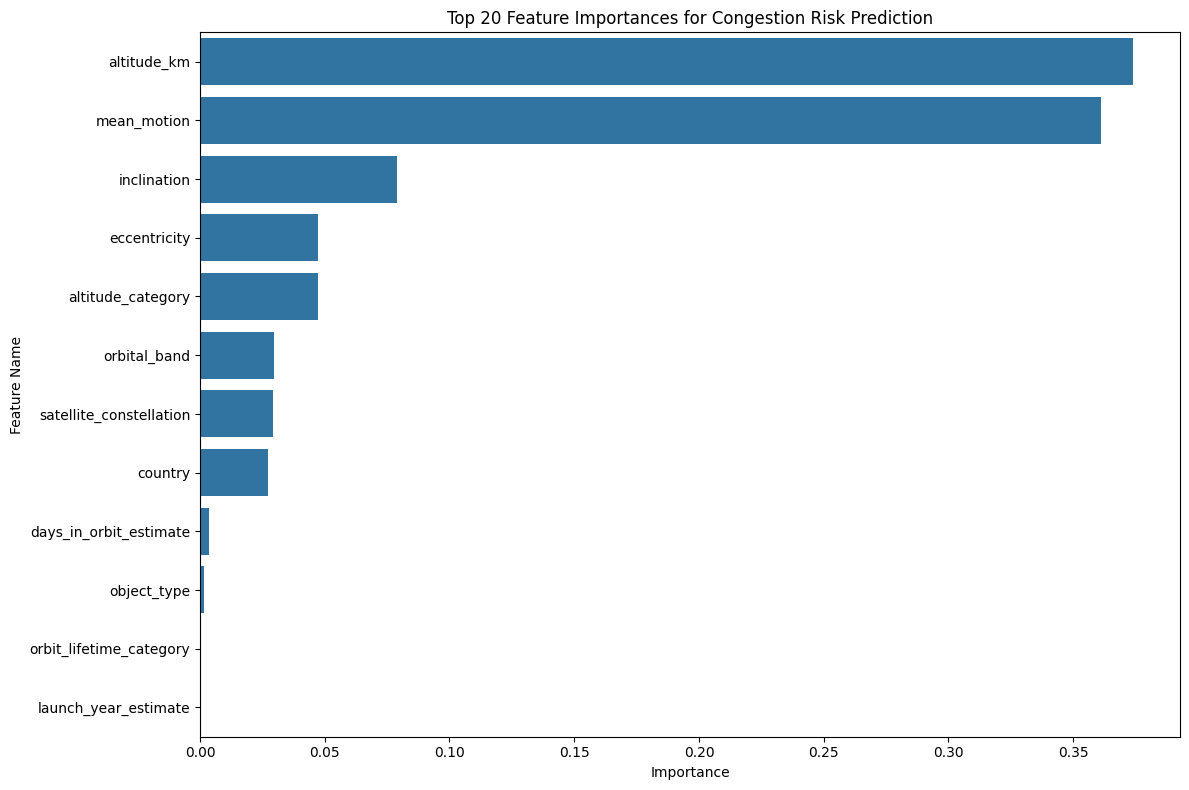

In [ ]:
# get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# get feature names from the processed (one-hot encoded) training data
feature_names = x_processed.columns

# create a pandas dataframe for better handling and sorting
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# sort features by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# plot the top N features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances for Congestion Risk Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

### 6. Visualizing Key Relationships: Top Features vs. Congestion Risk

After identifying the most important features, it can be useful to visualize how these features relate to the 'congestion_risk' categories. This helps us see if certain features have distinct value ranges for different risk levels.
Here we see that features like altitude and eccentricity have very low variance, while the altitude category or orbital band have much higher variance.

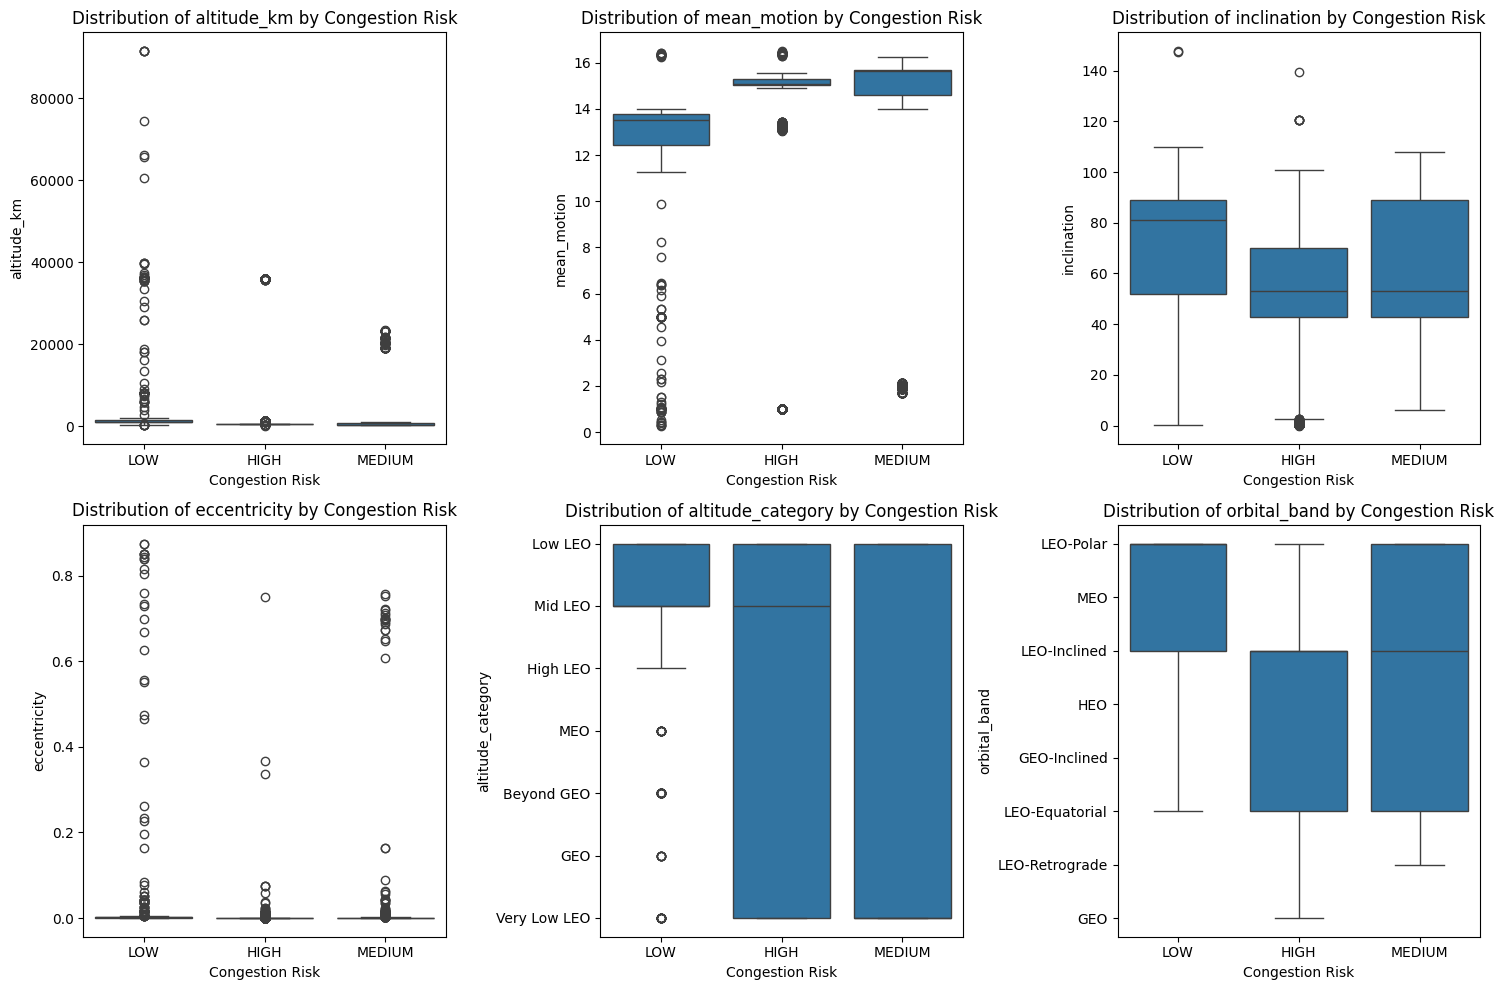

In [ ]:
#get top 6 features for plotting
top_6_features = importance_df['feature'].head(6).tolist()

#plot top 6 features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_6_features):
    plt.subplot(2, 3, i + 1) # Create subplots for each feature
    sns.boxplot(x='congestion_risk', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Congestion Risk')
    plt.xlabel('Congestion Risk')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


### 7. Deep Dive: Altitude and Mean Motion - The Primary Drivers

The previous plots showed that `altitude_km` and `mean_motion` are very strong predictors. To take a closer look, we'll plot these features against the satellite index, colour coding points by their congestion risk. To make the distributions more manageable and visible, we'll apply a `log` transformation to both altitude and mean motion. This compresses the scale for very large numbers, making patterns clearer.

What we expect to see here are clear distinctions or 'bands' where different congestion risk levels concentrate. This kind of separation is what allows a model like Random Forest to achieve high accuracy, as it can easily draw boundaries to classify satellites.

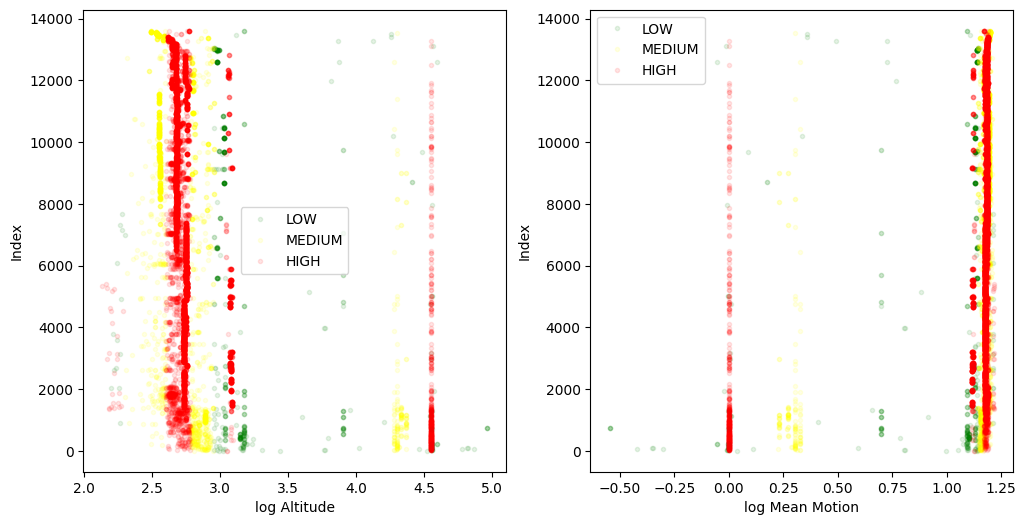

In [ ]:
# plot log altitude and log mean motion to show specific regions of different congestion risks
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.log10(x_processed[y=="LOW"].altitude_km),np.arange(len(y))[y=="LOW"],".",alpha=0.1, label='LOW', color="green")
plt.plot(np.log10(x_processed[y=="MEDIUM"].altitude_km),np.arange(len(y))[y=="MEDIUM"],".",alpha=0.1, label='MEDIUM', color="yellow")
plt.plot(np.log10(x_processed[y=="HIGH"].altitude_km),np.arange(len(y))[y=="HIGH"],".",alpha=0.1, label='HIGH', color="red")
plt.xlabel('log Altitude')
plt.ylabel('Index')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.log10(x_processed[y=="LOW"].mean_motion),np.arange(len(y))[y=="LOW"],".",alpha=0.1, label='LOW', color="green")
plt.plot(np.log10(x_processed[y=="MEDIUM"].mean_motion),np.arange(len(y))[y=="MEDIUM"],".",alpha=0.1, label='MEDIUM', color="yellow")
plt.plot(np.log10(x_processed[y=="HIGH"].mean_motion),np.arange(len(y))[y=="HIGH"],".",alpha=0.1, label='HIGH', color="red")
plt.xlabel('log Mean Motion')
plt.ylabel('Index')
plt.legend()

### 8. Conclusion: Why the Random Forest Model Shines Here

Our analysis clearly demonstrates that the Random Forest Classifier is an excellent choice for predicting satellite congestion risk based on this dataset.

The model achieved an accuracy of approximately 0.9996, which was consistently validated through cross-validation, indicating its reliability. Features like `altitude_km` and `mean_motion` emerged as overwhelmingly important, which is impactful because these features exhibit very distinct ranges for different congestion risk levels.

Decision-tree based models, like Random Forest, excel when data can be separated by clear thresholds or ranges within features. Our visualizations of altitude and mean motion showed precisely this, distinct regions where 'LOW', 'MEDIUM', and 'HIGH' risk satellites reside.

In summary, the inherent structure of the data, with its clear boundaries along key orbital parameters, perfectly aligns with the strengths of the Random Forest algorithm. This makes it a highly effective solution for classifying satellite congestion risk in this scenario.